# Hyperparameter Optimisation for CNNs 
In this project we consider the problem of hyperparameter tuning for convolutional neural networks (CNNs) with two convolutional layers. The aim is to classify images in the Fashion MINST dataset, which consists of 70,000 labelled black & white images of fashion items split into 10 categories. 60,000 of these observations are used for training and 10,000 for testing. We aim to optimise two hyperparameters, namely learning rate and drop out and explore two methodologies for doing this, Random Search (RS) and Bayesian Optimisation (BO). 

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
from time import time
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/Users/matthewkeys/Desktop/BigDataTopicsII/Hrvoje/fashionMNIST-bayesian-optimization'

In [4]:
# Hyper parameters
num_epochs = 1
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [5]:
from CNN_test_model import test_model

In [ ]:
test_model(dropout = 0.2, learning_rate = 0.001)

#### Random Search 
In this section we use random search (RS) to tune the hyperparameters of our CNN. This involves setting intervals or sets for each of the parameters we want to vary, and then randomly sampling from the a uniform distribution over them. The best performing set of hyperparameters is then chosen for the final model. 

In [6]:
from CNN_test_model import ConvNet

In [9]:
param_dist = {'dropout': [0,1],
             'learning_rate': [0,1]}
num_iterations = 10

In [12]:
def random_search(param_dist, num_iterations):
        
    sampled_values_error = {}
    for j in list(param_dist.keys()) + ["test_error"]:
        sampled_values_error[j] = [] 
        
    for i in range(num_iterations): 
        for j in param_dist.keys():
            sampled_values_error[j].append(np.random.uniform(0,1))
        sampled_values_error["test_error"].append(test_model(sampled_values_error["dropout"][i],
                                                            sampled_values_error["learning_rate"][i])) 
        
    max_index = np.argmax(sampled_values_error["test_error"])
    final_dropout = sampled_values_error["dropout"][max_index]
    final_learning_rate = sampled_values_error["learning_rate"][max_index] 
    final_test_error = sampled_values_error["test_error"][max_index] 
    
    return sampled_values_error, final_dropout, final_learning_rate, final_test_error        

In [13]:
dictionary, dropout, learning_rate, error = random_search(param_dist, num_iterations)

Epoch [1/1], Step [100/600], Loss: 1.2941
Epoch [1/1], Step [200/600], Loss: 1.0232
Epoch [1/1], Step [300/600], Loss: 1.0948
Epoch [1/1], Step [400/600], Loss: 1.1096
Epoch [1/1], Step [500/600], Loss: 1.4118
Epoch [1/1], Step [600/600], Loss: 1.2286
Test Accuracy of the model on the 10000 test images: 55.32 %
Epoch [1/1], Step [100/600], Loss: 1.4361
Epoch [1/1], Step [200/600], Loss: 1.3504
Epoch [1/1], Step [300/600], Loss: 1.0686
Epoch [1/1], Step [400/600], Loss: 1.2057
Epoch [1/1], Step [500/600], Loss: 0.9206
Epoch [1/1], Step [600/600], Loss: 1.1125
Test Accuracy of the model on the 10000 test images: 63.68 %
Epoch [1/1], Step [100/600], Loss: 1.7469
Epoch [1/1], Step [200/600], Loss: 1.5002
Epoch [1/1], Step [300/600], Loss: 1.2313
Epoch [1/1], Step [400/600], Loss: 1.1710
Epoch [1/1], Step [500/600], Loss: 1.0593
Epoch [1/1], Step [600/600], Loss: 1.0974
Test Accuracy of the model on the 10000 test images: 54.65 %
Epoch [1/1], Step [100/600], Loss: 1.7845
Epoch [1/1], Step [

#### Bayesian Optimisation
In this section we apply BO to optimise the learning rate and dropout in the convolutional neural network with two convolutional layers. We utilise the pyGPGO package which can be found at the following link https://github.com/hawk31/pyGPGO, which uses gaussian processes to form a posterior distribution over the function we are trying to optimise. 


In [14]:
import numpy as np
from pyGPGO.covfunc import matern32, dotProd
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

In [15]:
def bayes_optim(kernel, acquisition, param, max_iter):
    np.random.seed(1337)
    cov = kernel()
    gp = GaussianProcess(cov) 
    acq = Acquisition(mode=acquisition)
    gpgo = GPGO(gp, acq, test_model, param)
    gpgo.run(max_iter)
    return gpgo

In [36]:
param = {'learning_rate': ('cont', (0.1,1)),
        'dropout': ('cont', (0,1))}
max_iter = 10 

In [17]:
results = {} 
for kernel in [matern32, dotProd]: 
    for acquisition in ["ExpectedImprovement", "UCB"]:
        start_time = time() 
        results["results_"+kernel.__name__+"_"+acquisition] = [bayes_optim(kernel, acquisition,
                                                                         param, max_iter)]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Epoch [1/1], Step [100/600], Loss: 2.3262
Epoch [1/1], Step [200/600], Loss: 2.3122
Epoch [1/1], Step [300/600], Loss: 2.3725
Epoch [1/1], Step [400/600], Loss: 2.2933
Epoch [1/1], Step [500/600], Loss: 2.3213
Epoch [1/1], Step [600/600], Loss: 2.3010
Test Accuracy of the model on the 10000 test images: 9.93 %
Epoch [1/1], Step [100/600], Loss: 1.8976
Epoch [1/1], Step [200/600], Loss: 1.6284
Epoch [1/1], Step [300/600], Loss: 1.5974
Epoch [1/1], Step [400/600], Loss: 1.6414
Epoch [1/1], Step [500/600], Loss: 1.3170
Epoch [1/1], Step [600/600], Loss: 1.5340
Test Accuracy of the model on the 10000 test images: 39.49 %
Epoch [1/1], Step [100/600], Loss: 2.3558
Epoch [1/1], Step [200/600], Loss: 2.3287
Epoch [1/1], Step [300/600], Loss: 2.3209
Epoch [1/1], Step [400/600], Loss: 2.3425
Epoch [1/1], Step [500/600], Loss: 2.2835
Epoch [1/1], Step [600/600], Loss: 2.3242
Test Accuracy of the model on the 10000 test images: 9.76 %
init 

###### Results 
Here we present the results graphically for random search and bayesian optimisation for 10 iterations. We find that 


In [40]:
# Compute Bayesian Optimisation best test results at each iteration 
test_matern_EP = results['results_matern32_ExpectedImprovement'][0].history
test_matern_UCB = results['results_matern32_UCB'][0].history
test_linear_EP = results['results_dotProd_ExpectedImprovement'][0].history
test_linear_UCB = results['results_dotProd_UCB'][0].history

KeyError: 'results_matern32_UCB'

In [47]:
# Random Search best test results at each iteration 
RS_test = dictionary["test_error"]
RS_best_test = [RS_test[0]]

for i in range(1,len(RS_test)): 
    if RS_test[i] > RS_best_test[i-1]:
        RS_best_test.append(RS_test[i])
    else:
        RS_best_test.append(RS_best_test[i-1])

In [64]:
# iterations 
iterations = list(range(1,11))

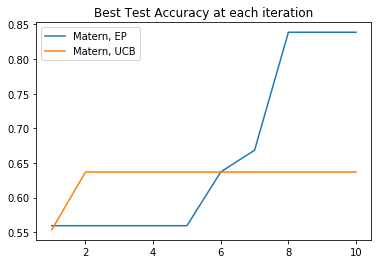

In [70]:
# Plot test results
plt.plot(iterations, test_matern_EP[1:11])
plt.plot(iterations, test_matern_UCB)
plt.plot(iterations, test_linear_EP)
plt.plot(iterations, test_linear_UCB)
plt.plot(iterations, RS_best_test)

plt.legend(['Matern, EP', 'Matern, UCB', 'Linear, EP', 'Linear, UCB', 'Random Search'],
           loc='upper left')
plt.title('Best Test Accuracy at each iteration')
plt.show()